In [88]:
import pandas as pd
from sklearn.model_selection import train_test_split
import stanza
import spacy
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

Ouvrir les CSV et diviser train en train et validation

In [107]:
df_test = pd.read_csv('../data/test.csv')
df_train = pd.read_csv('../data/train.csv')
df_test 

,doc_id,titre,type,difficulte,cout,ingredients,recette
0,recette_84191.xml,Roulé à la confiture de lait,Dessert,Moyennement difficile,Bon marché,- Pour la garniture: - 1 boîte de lait concent...,"La veille, préparer de la confiture de lait en..."
1,recette_26585.xml,Croissants aux amandes,Dessert,Moyennement difficile,Moyen,- 250 g de farine - 1 pincée de sel - 1 cuillè...,Croissants : Pétrir les ingrédients pour en fa...
2,recette_176139.xml,Quinoa Phileas (aux légumes croquants et sauci...,Plat principal,Moyennement difficile,Moyen,- 250 g de quinoa - 1 gros oignon blanc - 1 g...,Faites cuire le quinoa pendant 12 minutes dans...
3,recette_14285.xml,Magret de canard à la crème de mûre,Plat principal,Moyennement difficile,Moyen,- 1 magret de canard - 5 cl de crème de mûre -...,"Après avoir confectionné la sauce au vin, lui ..."
4,recette_20895.xml,St-Jacques a la sauce aux huitres et aux asperges,Entrée,Moyennement difficile,Moyen,- 10 cl de vin blanc sec - 18 asperges vertes ...,"Ouvrez, videz et nettoyez les coquilles Saint-..."
...,...,...,...,...,...,...,...
1383,recette_20785.xml,Galettes de pommes de terre aux navets,Plat principal,Facile,Moyen,- 750 g de pommes de terre - 750 g de navets -...,Râper les légumes et les assaisonner. Ajouter ...
1384,recette_28768.xml,Terrine d'aubergines au thon de Nadine (4ème r...,Entrée,Facile,Bon marché,"- 4 petits poivrons ou 3 gros, de chaque coule...","Laver les poivrons, les placer entiers dans un..."
1385,recette_73573.xml,Gateau aux amandes et fleur d'oranger,Dessert,Facile,Bon marché,- 250 g de farine - 1/2 sachet de levure - 1...,"Mélanger la farine, la levure, le sucre, la fl..."
1386,recette_166909.xml,Cailles au vin rouge,Plat principal,Facile,Moyen,- 4 - 6 cailles (dépend si ce sont de gros man...,"Tout d'abords, vérifier que vos cailles n'aien..."


In [133]:
df_train, df_validation = train_test_split(df_train, test_size=0.2, random_state=42)
print(df_train.shape, df_validation.shape, df_test.shape)

(5172, 8) (1293, 8) (1388, 8)


In [134]:
df_train.to_csv("../data/train1.csv", index=False)
df_validation.to_csv("../data/validation.csv", index=False)

Prétraitement

In [135]:
# nlp = stanza.Pipeline(lang="en", processors="tokenize,lemma")
    
# def lemmatize(text):
#     doc = nlp(text)
#     lemmas = [
#         word.lemma
#         for sentence in doc.sentences
#         for word in sentence.words
#     ]
#     return " ".join(lemmas)

# # faire une boucle pour ne prendre qu'une recette à la fois
# for i in range(len(df_train)):
#     df_train["recette"][i] = df_train["recette"][i].lower()
#     df_train["recette"][i] = lemmatize(df_train["recette"][i])
    
# df_train.to_csv("../data/train_pre.csv", index=False)
nlp = spacy.load("fr_core_news_sm")

def clean_text(text):
    doc = nlp(text)
    words = [token.text for token in doc if not token.is_stop]
    return " ".join(words)

df_train['cleaned_text'] = df_train['text'].apply(clean_text)
df_train['cleaned_text'] = df_train['text'].apply(clean_text)


OSError: [E050] Can't find model 'fr_core_news_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

In [136]:
df_train["text"] = df_train["titre"] + " " + df_train["recette"]
df_test["text"] = df_test["titre"] + " " + df_test["recette"]
df_validation["text"] = df_validation["titre"] + " " + df_validation["recette"]


In [144]:
vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(df_train['text'])
x_test = vectorizer.transform(df_test['text'])
x_validation = vectorizer.transform(df_validation['text'])

y_train = df_train['type']
y_test = df_test['type']
y_validation = df_validation['type']


encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)
y_validation_encoded = encoder.transform(y_validation)

# Afficher la répartition des étiquettes dans chaque sous-ensemble
print("Répartition des étiquettes dans le sous-ensemble d'entraînement (train) :")
print(y_train.value_counts(normalize=True))

print("\nRépartition des étiquettes dans le sous-ensemble de test (test) :")
print(y_test.value_counts(normalize=True))

print("\nRépartition des étiquettes dans le sous-ensemble de validation (validation) :")
print(y_validation.value_counts(normalize=True))




Répartition des étiquettes dans le sous-ensemble d'entraînement (train) :
type
Plat principal    0.459397
Dessert           0.305878
Entrée            0.234725
Name: proportion, dtype: float64

Répartition des étiquettes dans le sous-ensemble de test (test) :
type
Plat principal    0.463977
Dessert           0.293228
Entrée            0.242795
Name: proportion, dtype: float64

Répartition des étiquettes dans le sous-ensemble de validation (validation) :
type
Plat principal    0.479505
Dessert           0.294664
Entrée            0.225831
Name: proportion, dtype: float64


Baseline (random?)

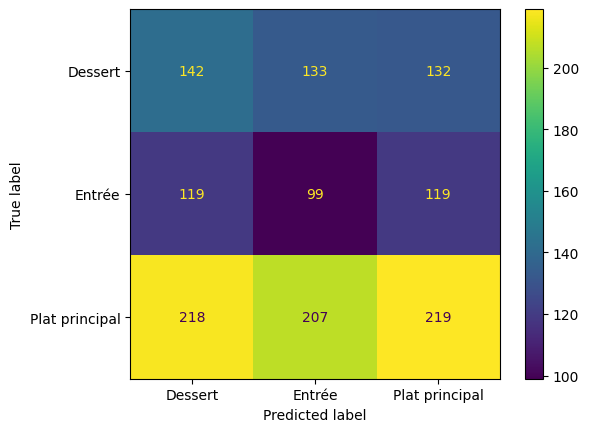

                precision    recall  f1-score   support

       Dessert       0.30      0.35      0.32       407
        Entrée       0.23      0.29      0.26       337
Plat principal       0.47      0.34      0.39       644

      accuracy                           0.33      1388
     macro avg       0.33      0.33      0.32      1388
  weighted avg       0.36      0.33      0.34      1388



In [138]:
classes = np.unique(y_train) 
random_predictions = np.random.choice(classes, size=len(y_test))
generate_confusion_matrix(random_predictions, y_test)
print(classification_report(y_test,random_predictions))


Arbre de décision

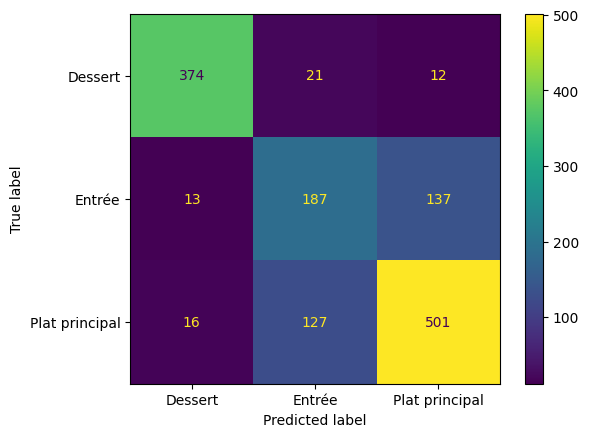

                precision    recall  f1-score   support

       Dessert       0.93      0.92      0.92       407
        Entrée       0.56      0.55      0.56       337
Plat principal       0.77      0.78      0.77       644

      accuracy                           0.77      1388
     macro avg       0.75      0.75      0.75      1388
  weighted avg       0.77      0.77      0.77      1388



In [139]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)

generate_confusion_matrix(predictions, y_test)
print(classification_report(y_test,predictions))



SVM

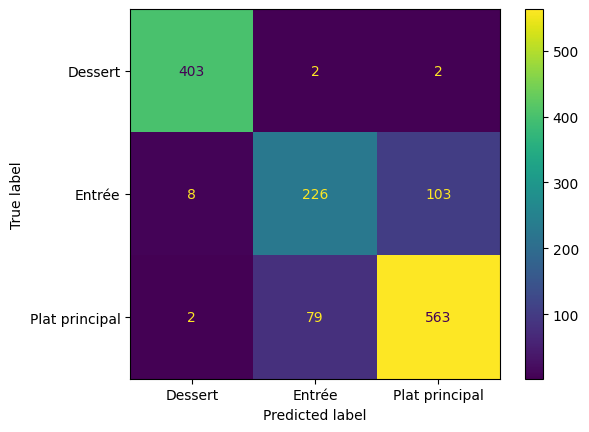

                precision    recall  f1-score   support

       Dessert       0.98      0.99      0.98       407
        Entrée       0.74      0.67      0.70       337
Plat principal       0.84      0.87      0.86       644

      accuracy                           0.86      1388
     macro avg       0.85      0.85      0.85      1388
  weighted avg       0.86      0.86      0.86      1388



In [140]:

model = SVC(kernel='linear')
model.fit(x_train, y_train_encoded)

y_pred_encoded = model.predict(x_test)

y_pred = encoder.inverse_transform(y_pred_encoded)

generate_confusion_matrix(y_pred, y_test)
print(classification_report(y_test,y_pred))


Random forest

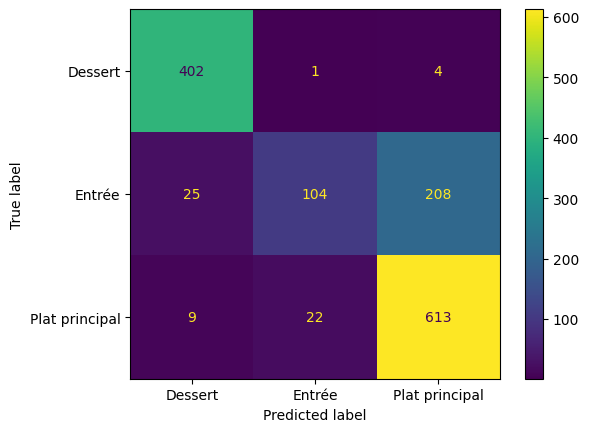

                precision    recall  f1-score   support

       Dessert       0.92      0.99      0.95       407
        Entrée       0.82      0.31      0.45       337
Plat principal       0.74      0.95      0.83       644

      accuracy                           0.81      1388
     macro avg       0.83      0.75      0.75      1388
  weighted avg       0.81      0.81      0.78      1388



In [141]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(x_train, y_train_encoded)

y_pred_encoded = model.predict(x_test)

y_pred = encoder.inverse_transform(y_pred_encoded)

generate_confusion_matrix(y_pred, y_test)
print(classification_report(y_test,y_pred))


Naive Bayes

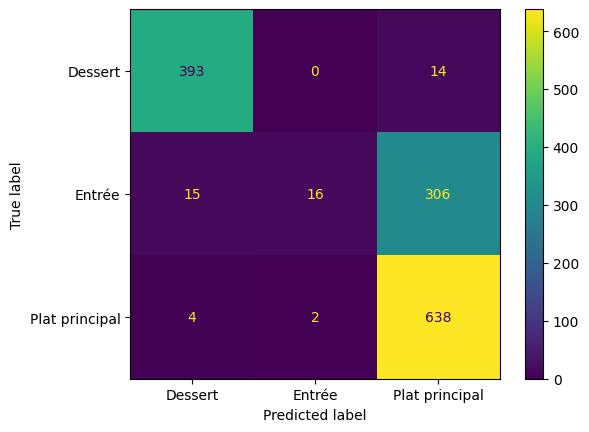

                precision    recall  f1-score   support

       Dessert       0.95      0.97      0.96       407
        Entrée       0.89      0.05      0.09       337
Plat principal       0.67      0.99      0.80       644

      accuracy                           0.75      1388
     macro avg       0.84      0.67      0.62      1388
  weighted avg       0.80      0.75      0.67      1388



In [142]:


model = MultinomialNB()
model.fit(x_train, y_train_encoded)

y_pred_encoded = model.predict(x_test)

y_pred = encoder.inverse_transform(y_pred_encoded)

generate_confusion_matrix(y_pred, y_test)
print(classification_report(y_test,y_pred))



Générer une matrice de confusion

In [143]:
def generate_confusion_matrix(prediction, classes):
    labels = sorted(list(set(classes)))
    cm = confusion_matrix(classes, prediction, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.show()